<a href="https://colab.research.google.com/github/evamargin/NMA/blob/main/tutorials/W0D3_LinearAlgebra/student/W0D3_Tutorial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bonus Tutorial: Discrete Dynamical Systems

**Week 0, Day 3: Linear Algebra**

**By Neuromatch Academy**

**Content creators:** Ella Batty

**Production editors:** Ella Batty

---
# Tutorial Objectives

In this tutorial, we will start to gain an intuition for how eigenvalues and eigenvectors can be helpful for understanding dynamical systems. We will focus on a discrete dynamical system consisting of two neurons.

By the end of the tutorial, you will:

* Predict whether the firing rates of interconnected model neurons will explode or decay based on the eigenvalues of the weight matrix.
* Apply ideas from previous tutorials (linear combination, basis vectors, etc) to understand a new concept





---
# Setup

In [ ]:
# @title Install and import feedback gadget

!pip3 install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch-precourse",
            "user_key": "8zxfvwxw",
        },
    ).render()


feedback_prefix = "W0D3_Bonus"

In [1]:
# Imports
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [4]:
# @title Figure settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

In [2]:
# @title Plotting functions

def plot_circuit_responses(u, W, eigenstuff = False,
                           xlim='default',
                           ylim='default'):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Set up axis limits
    if xlim == 'default':
      extreme = np.maximum(np.abs(np.min(u)), np.max(u))
      xlim = [- extreme, extreme]
    if ylim == 'default':
      extreme = np.maximum(np.abs(np.min(u)), np.max(u))
      ylim = [- extreme, extreme]

    # Set up look
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    cs = plt.rcParams['axes.prop_cycle'].by_key()['color']*10
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Set up tracking textz
    tracker_text = ax.text(.5, .9, "", color='w',
                           fontsize=20,
                           verticalalignment='top',
                           horizontalalignment='left',
                           transform=ax.transAxes)

    # Plot eigenvectors
    if eigenstuff:
      eigvals, eigvecs = np.linalg.eig(W)

      if np.abs(eigvals[0]) < np.abs(eigvals[1]):
        lc1 = 'c'
        lc2 = 'g'
      else:
        lc1 = 'g'
        lc2 = 'c'

      ax.plot(np.arange(-10000, 10000)*eigvecs[0, 0],
              np.arange(-10000, 10000)*eigvecs[1, 0],
              lc1, alpha=.5, label = r'$\mathbf{v}_1$')
      ax.plot(np.arange(-10000, 10000)*eigvecs[0, 1],
              np.arange(-10000, 10000)*eigvecs[1, 1],
              lc2, alpha=.5, label = r'$\mathbf{v}_2$')
      ax.legend()

    # Set up scatter
    cmap = plt.cm.coolwarm
    norm = plt.Normalize(vmin=0, vmax=u.shape[1])
    ax.plot(u[0,:], u[1, :], alpha=.4, zorder = 0)
    scatter = ax.scatter(u[0, :], u[1, :], alpha=1,
                         c=cmap(norm(np.arange(u.shape[1]))),
                         zorder=1)


    ax.set(xlabel='Neuron 1 Firing Rate ($a_1$)',
           ylabel='Neuron 2 Firing Rate ($a_2$)',
           title='Neural firing over time')

    fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
                 ax=ax, label='Time step')

In [3]:
# @title Helper functions

def get_eigval_specified_matrix(target_eig):
  """Generates matrix with specified eigvals

    Args:
      target_eig (list): list of target eigenvalues, can be real or complex,
              should be length 2 unless you desire repeated eigenvalues
              with the same eigenvector, in which case length 1

    Returns:
      ndarray: 2 x 2 matrix with target eigvals

  """

  # Set up two eigenvectors
  V = np.array([[1, 1], [-1, 1]]).astype('float')
  for i in range(2):
    V[:, i] = V[:, i]/np.linalg.norm(V[:, i])

  # Get matrix with target eigenvalues
  if type(target_eig[0]) == int or type(target_eig[0]) == float:

    if len(target_eig) == 2: # distinct eigvecs (not necessarily distinct eigvals)

        D = np.diag(target_eig)
        A = V @ D @ np.linalg.inv(V)

    else: # repeated with same vec
      summed = 2*target_eig[0]

      a = summed - 3
      d = 3
      bc = target_eig[0]**2 - a*d
      factors = [n for n in range(1, bc+ 1) if bc % n == 0]
      b = factors[int(np.floor(len(factors)/2))]
      c = bc/-b

      A = np.array([[a, b], [c, d]])

  elif type(target_eig[0]) == complex:

      C = [np.real(V[:,0]), np.real(V[:,1])]
      B = np.array([[np.real(target_eig[0]), np.imag(target_eig[0])],
                    [-np.imag(target_eig[0]), np.real(target_eig[0])]]).squeeze()
      A = C @ B @ np.linalg.inv(C)

  return A

---

# Section 1: Defining a neural circuit





**Please note a correction to the video appearing below it**


In [ ]:
# @title Video 1: A neural circuit
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'XJu2bQgnn9M'), ('Bilibili', 'BV1564y1b78X')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_A_neural_circuit_Video")

This video covers our neural circuit we will be working with in this tutorial.

**Please note this correction to the video: I had wrong subscripts for weights in the equations and matrix. These should be:**

\begin{aligned}
a_{1, t} &= w_{1, 1}a_{1, t-1} + w_{2, 1}a_{2, t-1}\\
a_{2, t} &= w_{1, 2}a_{1, t-1} + w_{2, 2}a_{2, t-1}
\end{aligned}

<br>

\begin{equation}
\mathbf{W} = \begin{bmatrix} w_{1, 1} & w_{2, 1} \\ w_{1, 2} & w_{2, 2} \end{bmatrix}, \mathbf{a}_{t} =   \begin{bmatrix} a_{1, t} \\ a_{2, t} \end{bmatrix}
\end{equation}

<details>
<summary> <font color='blue'>Click here for text recap of video </font></summary>

In previous tutorials, we have looked at static models of LGN neurons based on the responses of retinal neurons. By static, I mean that we just looked at a single time point.

Let's now introduce the concept of time. We will chop time up into little bins and look at the activity of neurons in each bin. That is, we will work in a **discrete** time framework. For example, if each bin is 1 second long, we will look at the firing rate of each neuron at intervals of a second.

Instead of examining pre- and post- synaptic neurons, we will examine two neurons in one area that are connected. In our model, the activity of neuron 1 at one time bin depends on the activities of both neurons during the previous time bin multiplied by the respective weights from itself and neuron 2. It might seem weird for a neuron to have a weight to itself - this is abstracting away some biological details but basically conveys how much the neural activity depends on its history. (Throughout this course, we'll see lots of neuron models and how some model biological detail more faithfully while others abstract.)

We will refer to the activity of neuron i during time bin j as $a_{i, j}$. The weight from neuron y to neuron x will be $w_{y, x}$. With this helpful notation, we can write an equation for the activity of neuron 1 at time bin t:

\begin{equation}
a_{1, t} = w_{1, 1}a_{1, t-1} + w_{2, 1}a_{2, t-1}
\end{equation}

And the symmetric model is true of neuron 2:
\begin{equation}
a_{2, t} = w_{1, 2}a_{1, t-1} + w_{2, 2}a_{2, t-1}
\end{equation}

This is already a mess of subscript numbers - luckily we can use matrices and vectors once again and our model becomes:

\begin{equation}
\mathbf{a}_{t} = \mathbf{W}\mathbf{a}_{t-1}
\end{equation}

where:

\begin{equation}
\mathbf{W} = \begin{bmatrix} w_{1, 1} & w_{2, 1} \\ w_{1, 2} & w_{2, 2} \end{bmatrix}, \mathbf{a}_{t} =   \begin{bmatrix} a_{1, t} \\ a_{2, t} \end{bmatrix}\end{equation}

It turns out that this is a **discrete dynamical system**. Dynamical systems are concerned with how quantities evolve other time, in this case our neural firing rates. When we model the evolution of quantities over time using a discrete time framework, it is, unsurprisingly, a discrete dynamical system. We will see continuous dynamical systems (where we embrace the full continuity of time) tomorrow and later in the comp neuro course during W2D2: Linear Dynamics.


## Coding Exercise 1: Implementing the circuit

In this exercise, you will implement the function `circuit_implementation`. Given a weight matrix, initial activities at time 0, and a number of time bins to model, this function calculates the neural firing rates at each time bin.

We will use initial firing rates of 1 for both neurons:

\begin{equation}
\mathbf{a}_0 =
\begin{bmatrix}
1 \\
1
\end{bmatrix}
\end{equation}

and the weight matrix:

\begin{equation}
\mathbf{W} =
\begin{bmatrix}
1 & 0.2 \\
0.1 & 1
\end{bmatrix}
\end{equation}

We will look at activity over 30 time steps. As before, we will allow our firing rates to be negative, despite this not being possible biologically.


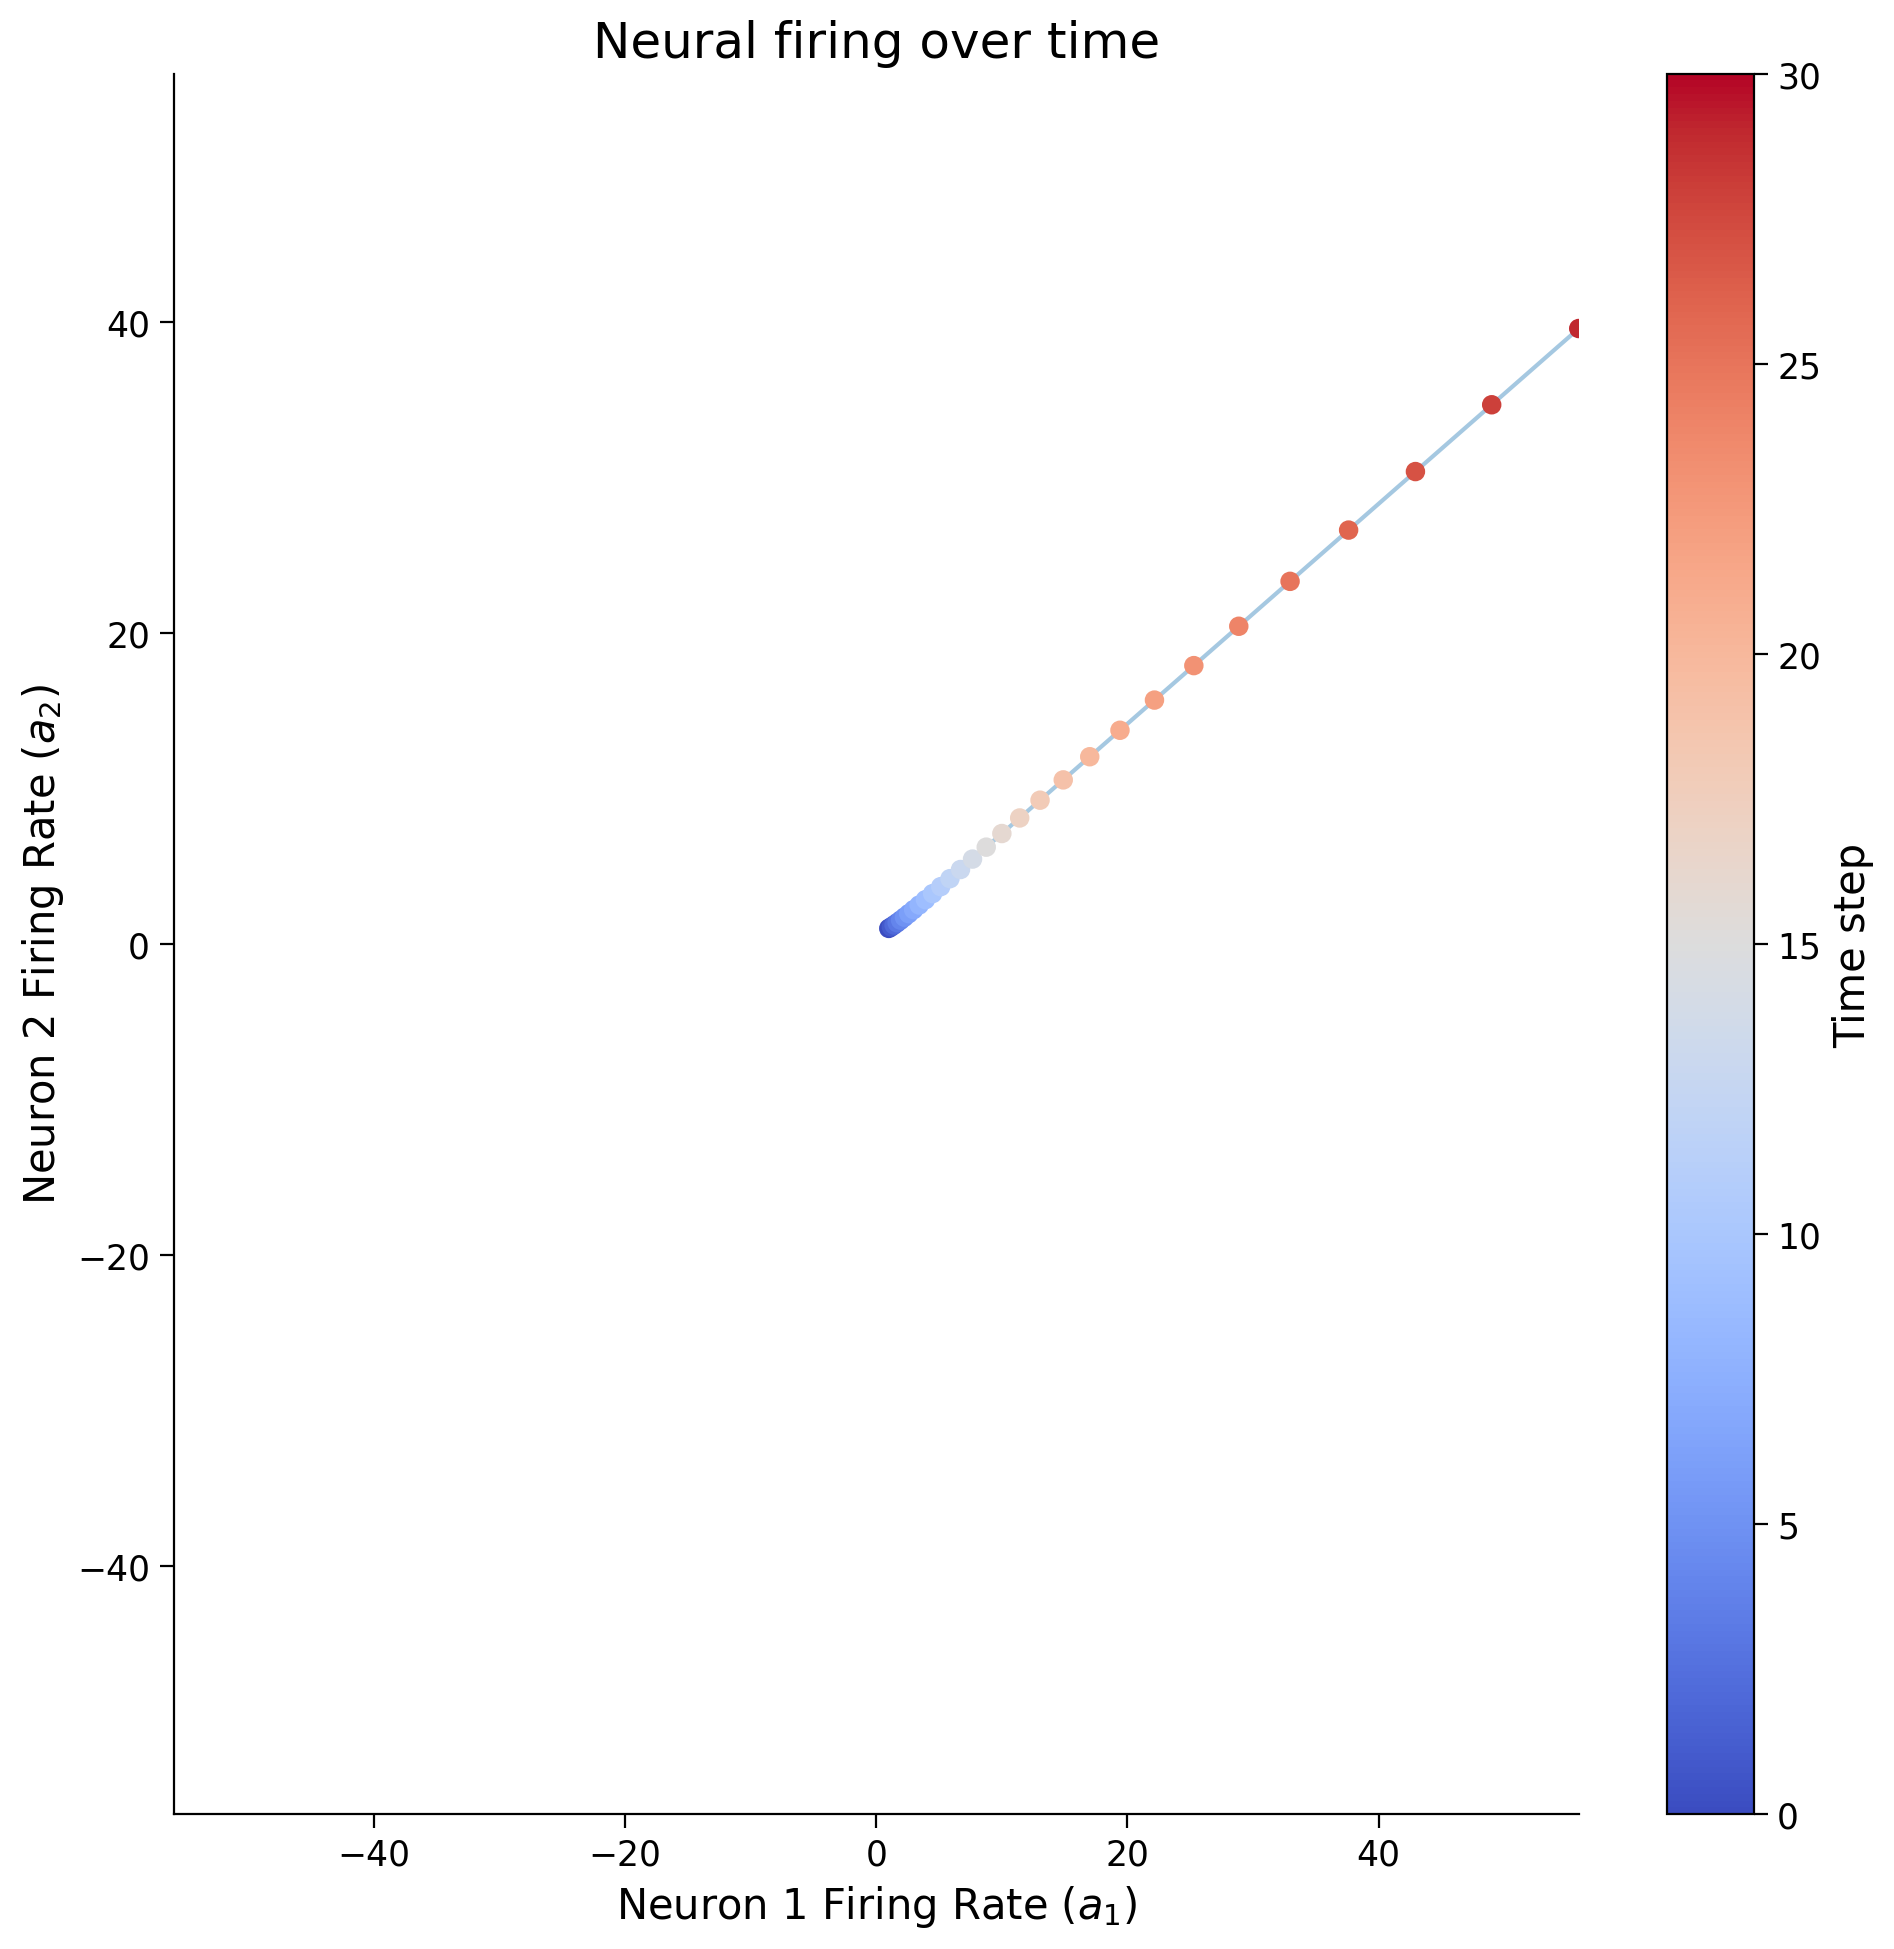

In [5]:
def circuit_implementation(W, a0, T):
  """ Simulate the responses of N neurons over time given their connections

  Args:
    W (ndarray): weight matrix of synaptic connections, should be N x N
    a0 (ndarray): initial condition or input vector, should be N,
    T (scalar): number of time steps to run simulation for

  Returns:
    a (ndarray): the neural responses over time, should be N x T

  """

  # Compute the number of neurons
  N = W.shape[0]

  # Initialize empty response array and initial condition
  a = np.zeros((N, T))
  a[:, 0]  = a0

  # Loop over time steps and compute u(t+1)
  for i_t in range(1, T):
      a[:, i_t] = W@a[:, i_t-1]

  return a


# Define W, u0, T
W = np.array([[1, .2], [.1, 1]])
a0 = np.array([1, 1])
T = 30

# Get neural activities
a = circuit_implementation(W, a0, T)

# Visualize neural activities
plot_circuit_responses(a, W)

[*Click for solution*](https://github.com/NeuromatchAcademy/precourse/tree/main/tutorials/W0D3_LinearAlgebra/solutions/W0D3_Tutorial3_Solution_9b2ef069.py)

*Example output:*

<img alt='Solution hint' align='left' width=939.0 height=975.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/precourse/main/tutorials/W0D3_LinearAlgebra/static/W0D3_Tutorial3_Solution_9b2ef069_1.png>



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Implementing_the_circuit_Exercise")

The firing rates of both neurons are exploding to infinity over time. Let's now see what happens with a different weight matrix:

\begin{equation}
\mathbf{W} =
\begin{bmatrix}
0.2 & 0.1 \\
1 & 0.2
\end{bmatrix}
\end{equation}

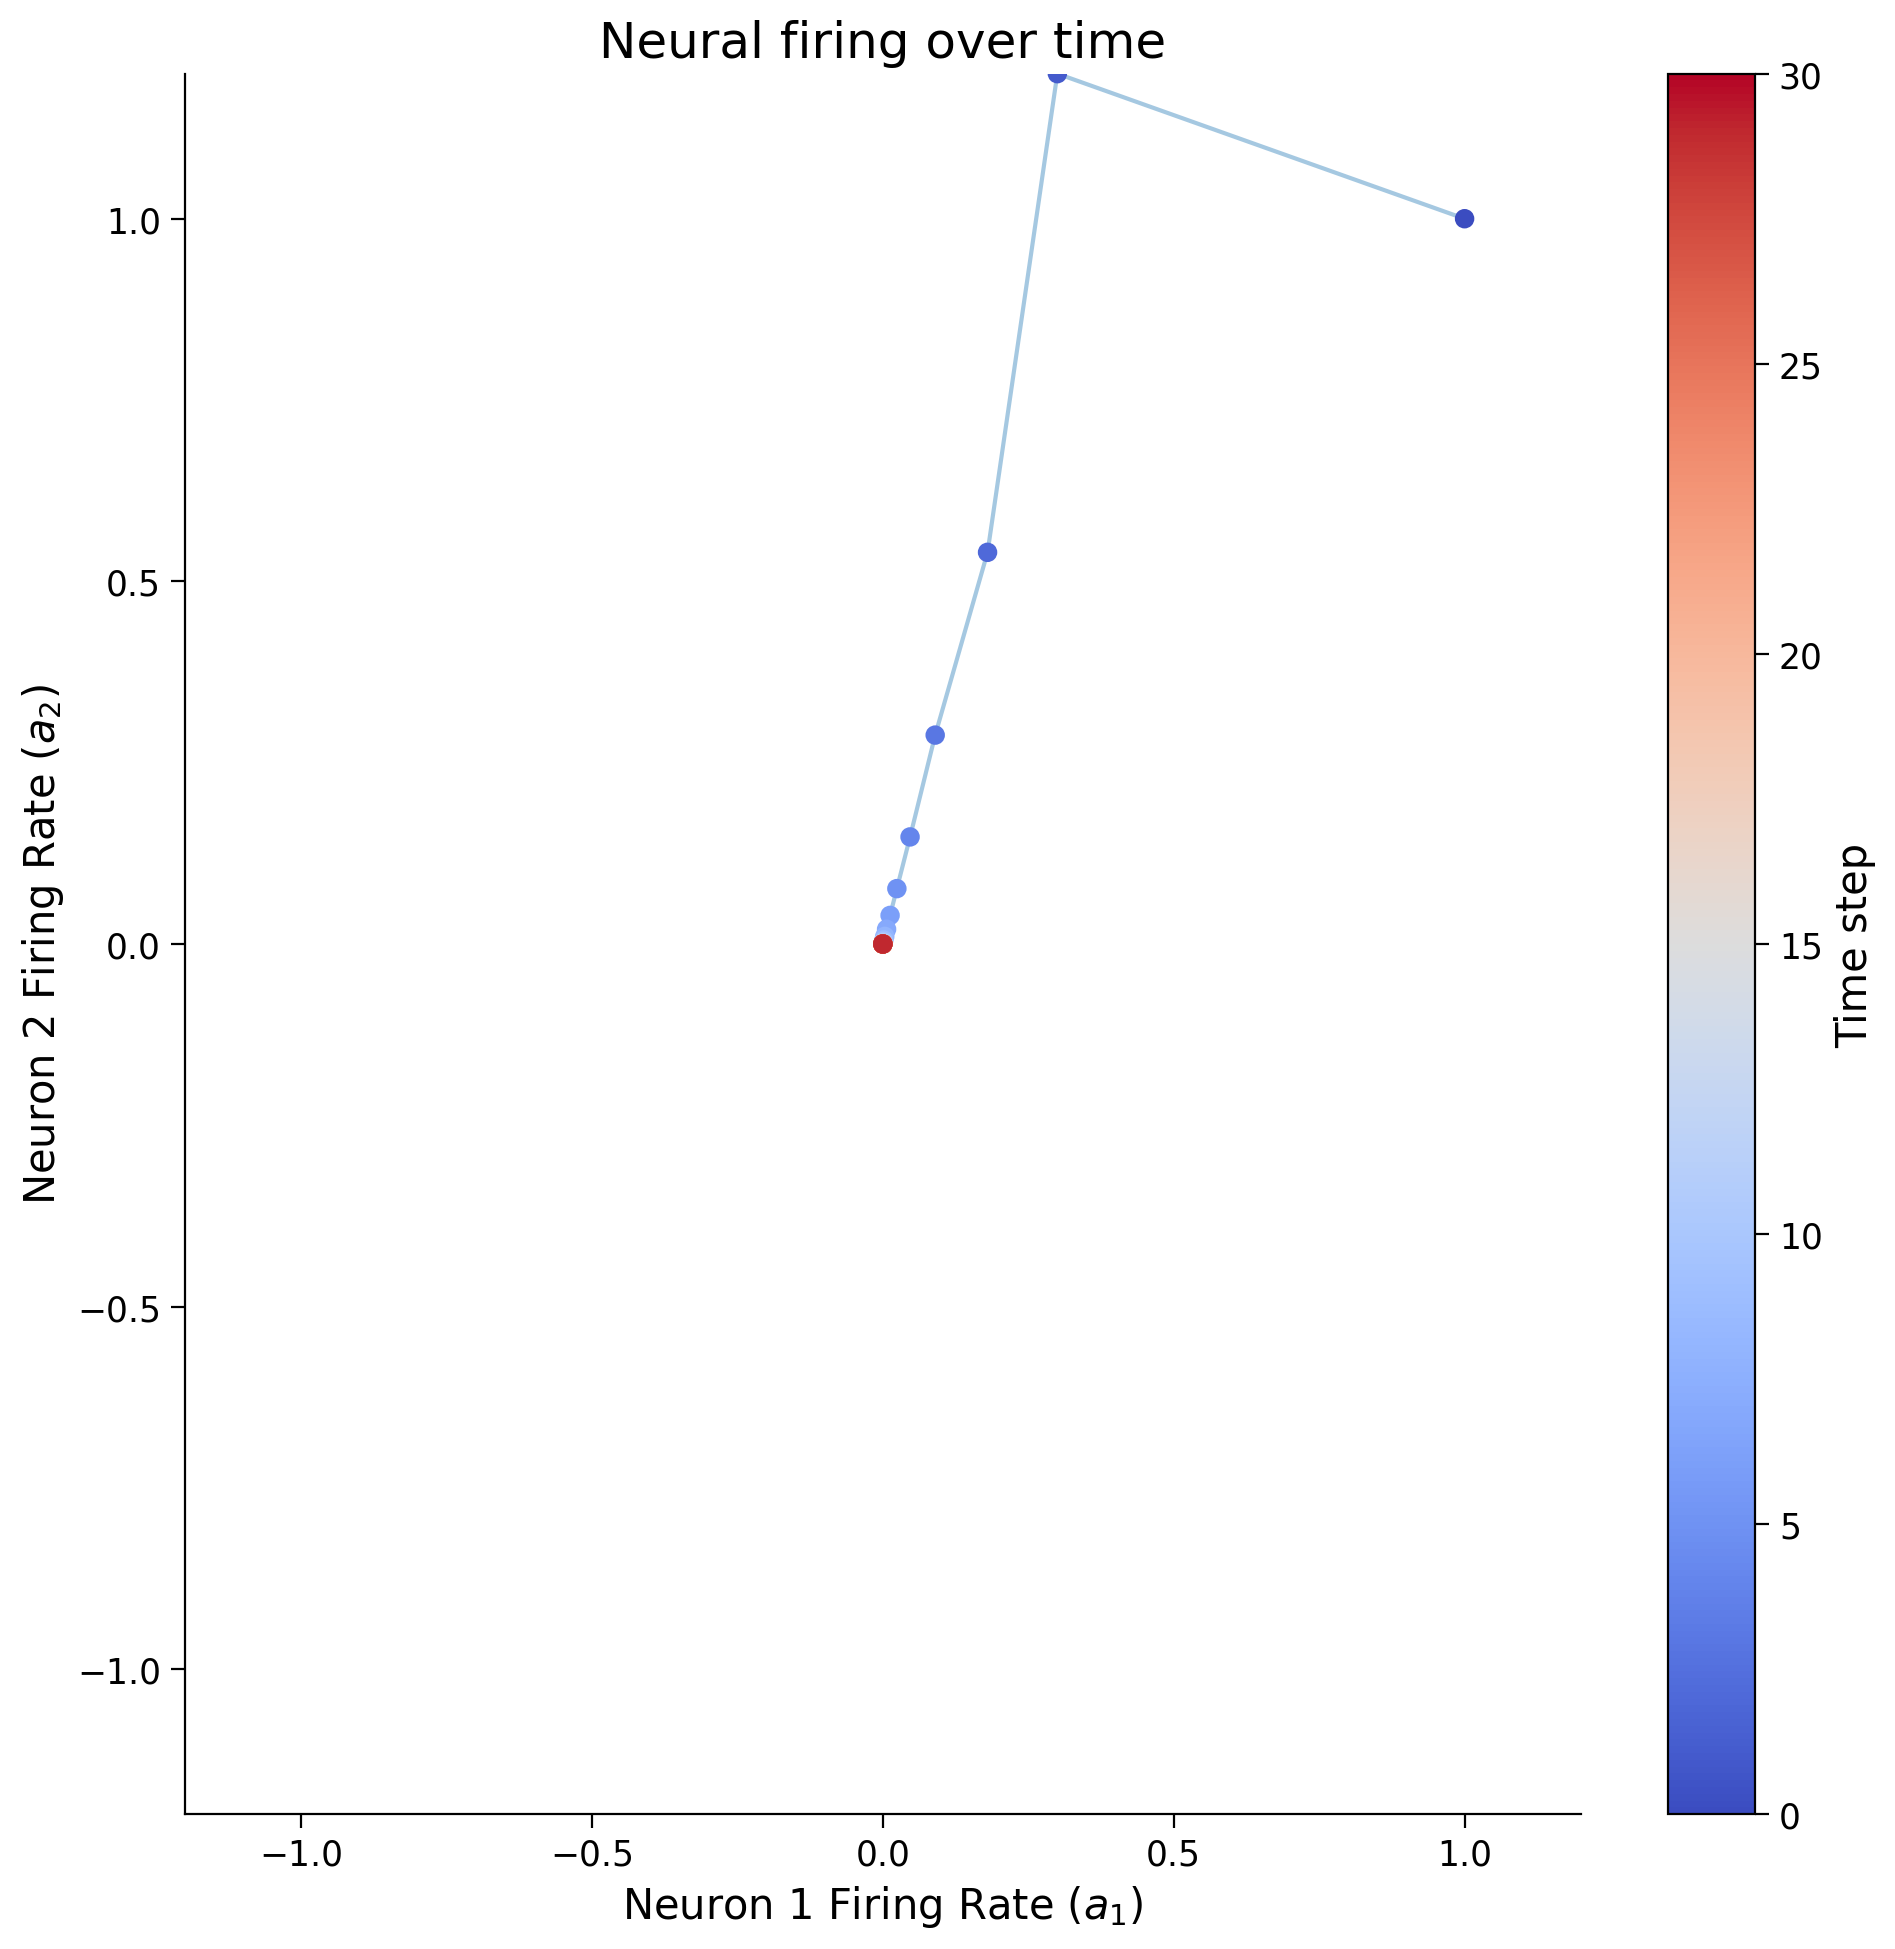

In [6]:
# @markdown Execute this cell to visualize activity over time

# Define W, a0, T
W = np.array([[.2, .1], [1, .2]])
a0 = np.array([1, 1])
T = 30

# Get neural activities
a = circuit_implementation(W, a0, T)

# Visualize neural activities
plot_circuit_responses(a, W)

We can see that with this weight matrix, the firing rates are decaying towards zero. It turns out that we could have predicted this by looking at the eigenvalues of the weight matrices, as we'll see in the next section.

---
# Section 2: Understanding dynamics using eigenstuff

As we'll see in this section, eigenvectors and eigenvalues are incredibly useful for understanding the evolution of the neural firing rates, and discrete dynamical systems in general.



## Section 2.1: Initial firing rates along an eigenvector


**Please note this correction to the video: the equation at the bottom of slide 115 (at 2:31) should be: $a_i = W^ia_0$**

In [ ]:
# @title Video 2: Looking at activity along an eigenvector
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'BnSvcWbYf8g'), ('Bilibili', 'BV1Tf4y1b7de')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

**Note:** In 2.30 the equation for $\text{a}_i$ should be $\text{a}_i = W^i  a_0$

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Looking_at_activity_along_an_eigenvector_Video")

This video covers what happens if our initial firing rates fall along one of the eigenvectors of the weight matrix.

<details>
<summary> <font color='blue'>Click here for text recap of video </font></summary>

**Rewriting our circuit equation**

In our neural circuit, we are modeling the activities at a time step as:
$$\mathbf{a}_{t} = \mathbf{W}\mathbf{a}_{t-1} $$

Let's start at time  step 1:
$$\mathbf{a}_{1} = \mathbf{W}\mathbf{a}_{0} $$

And move on to time step 2:
$$\mathbf{a}_{2} = \mathbf{W}\mathbf{a}_{1} $$

In the above equation, we can subsitute in $\mathbf{a}_{1} = \mathbf{W}\mathbf{a}_{0}$:
$$\mathbf{a}_{2} = \mathbf{W}\mathbf{W}\mathbf{a}_{0} = \mathbf{W}^2 \mathbf{a}_{0}$$

We can keep doing this with subsequent time steps:
$$\mathbf{a}_{3} = \mathbf{W}\mathbf{a}_{2} = \mathbf{W}\mathbf{W}^2 \mathbf{a}_{0} = \mathbf{W}^3\mathbf{a}_{0}  $$
$$\mathbf{a}_{4} = \mathbf{W}\mathbf{a}_{3} = \mathbf{W}\mathbf{W}^3 \mathbf{a}_{0} = \mathbf{W}^4\mathbf{a}_{0}  $$

This means that we can write the activity at any point as:
$$\mathbf{a}_{i} = \mathbf{W}^i\mathbf{a}_{0}  $$

**Initial firing rates along an eigenvector**

Remember from the last tutorial, that an eigenvector of matrix $\mathbf{W}$ is a vector that becomes a scalar multiple (eigenvalue) of itself when multiplied by that matrix:

$$\mathbf{W}\mathbf{v} = \lambda\mathbf{v}$$

Let's look at what happens if the initial firing rates in our neural circuit lie along that eigenvector, using the same substitution method as in the previous section:
$$\mathbf{a}_{0} = \mathbf{v} $$
$$\mathbf{a}_{1} = \mathbf{W}\mathbf{a}_0 = \mathbf{W}\mathbf{v} = \lambda\mathbf{v} $$
$$\mathbf{a}_{2} = \mathbf{W}\mathbf{a}_1 = \mathbf{W}\lambda\mathbf{v} = \lambda\mathbf{W}\mathbf{v} = \lambda^2\mathbf{v}$$
$$\mathbf{a}_{3} = \mathbf{W}\mathbf{a}_2 = \mathbf{W}\lambda^2\mathbf{v} = \lambda^2\mathbf{W}\mathbf{v} = \lambda^3\mathbf{v}$$
$$...$$
$$\mathbf{a}_i = \lambda^i\mathbf{v}$$

The activities at any time step equal a scalar times the initial activities. In other words, if the initial activities lie along an eigenvector, the activities will only evolve along that eigenvector.

### Interactive demo 2.1: Changing the eigenvalue

Let's visualize what happens if the initial activities of the neurons lie along an eigenvector and think about how this depends on the eigenvalue.

The interactive demo below is the same visualization you saw in Section 1, but now we also plot the eigenvectors $\mathbf{v}_1$ and $\mathbf{v}_2$.

Questions:
1.  What happens if the eigenvalue is large (2)?
2.  What happens if you move the eigenvalue from 2 to towards 0?
3.  What happens with negative eigenvalues?

In [7]:
# @markdown Execute this cell to enable the widget. Please be patient for a few seconds after you change the slider

@widgets.interact(eigenvalue = widgets.FloatSlider(value=0.5, min=-2, max=2, step=0.2))
def plot_system(eigenvalue):

  # Get weight matrix with specified eigenvalues
  W = get_eigval_specified_matrix([eigenvalue, eigenvalue])

  # Get initial condition
  u0 = np.array([1, 1])

  # Get neural activities
  u = circuit_implementation(W, u0, 10)

  # Visualize neural activities
  plot_circuit_responses(u, W, eigenstuff = True, xlim = [-15, 15], ylim = [-15, 15])

interactive(children=(FloatSlider(value=0.5, description='eigenvalue', max=2.0, min=-2.0, step=0.2), Output())…

[*Click for solution*](https://github.com/NeuromatchAcademy/precourse/tree/main/tutorials/W0D3_LinearAlgebra/solutions/W0D3_Tutorial3_Solution_3c096483.py)



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Changing_the_eigenvalue_Interactive_Demo")

## Section 2.2: Understanding general dynamics using eigenstuff

In [ ]:
# @title Video 3: Understanding general dynamics using eigenstuff
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', '66DExLQPzPI'), ('Bilibili', 'BV1fX4y1c7y7')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Understanding_general_dynamics_using_eigenstuff_Video")

This video covers how the eigenvalues and eigenvectors of the weight matrix affect the neural activities more generally.

<details>
<summary> <font color='blue'>Click here for text recap of video </font></summary>

We now know that if our initial activities (or initial condition) fall on an eigenvector of $\mathbf{W}$, the activities will evolve along that line, either exploding to infinity if the absolute value of the eigenvalue is above 1 or decaying to the origin it it is below 1. What if our initial condition doesn't fall along the eigenvector though?

To understand what will happen, we will use the ideas of basis vectors and linear combinations from Tutorial 1.

Let's assume for now that our weight matrix has two distinct eigenvectors ($\mathbf{v}_1$ and $\mathbf{v}_2$) with corresponding eigenvalues $\lambda_1$ and $\lambda_2$, and that these eigenvectors form a basis for 2D space. That means we can write any vector in 2D space as a linear combination of our eigenvectors, including our initial activity vector:

\begin{equation}
\mathbf{a}_0 = c_1\mathbf{v}_1 + c_2\mathbf{v}_2
\end{equation}

Let's compute the next time step, using our previous strategy of substitution:

\begin{align}
\mathbf{a}_1 &= \mathbf{W}\mathbf{a}_0 \\
&= \mathbf{W}(c_1\mathbf{v}_1 + c_2\mathbf{v}_2) \\
&= c_1\mathbf{W}\mathbf{v}_1 + c_2\mathbf{W}\mathbf{v}_2 \\
&= c_1\lambda_1\mathbf{v}_1 + c_2\lambda_2\mathbf{v}_2
\end{align}

All activities can be written as:

\begin{equation}
\mathbf{a}_i = c_1\lambda_1^i\mathbf{v}_1 + c_2\lambda_2^i\mathbf{v}_2
\end{equation}

We'll see what this means for our system in the next demo.

Before we get to the neural circuit, refresh your memory on linear combinations briefly by looking at our widget from tutorial 1 below. What happens when the absolute values of both scalar multiples of both vectors is big? What about when one is big and one is small?

In [ ]:
 #@markdown Make sure you execute this cell to enable the widget! Move the sliders for “a” and “b”. After releasing the slider, be patient for a couple of seconds to see the desired change.


def plot_arrows(x, y, a_times_x, b_times_y):
  fig, ax = plt.subplots(figsize=(10, 7))

  ax.spines['top'].set_color('none')
  ax.spines['bottom'].set_position('zero')
  ax.spines['left'].set_position('zero')
  ax.spines['right'].set_color('none')

  ax.set_aspect('equal', adjustable='box')
  ax.set(xlim = [-10, 10], ylim = [-10, 10], xticks = np.arange(-10, 10), yticks = np.arange(-10, 10), xticklabels = [], yticklabels = [])

  ax.grid(alpha=.4)

  z = a_times_x + b_times_y
  z_arr = ax.arrow(0, 0, z[0], z[1], width=.08, color='k', length_includes_head = True);

  x_orig, = ax.plot([0, x[0]], [0, x[1]], '--', color='#648FFF')
  y_orig, = ax.plot([0, y[0]], [0, y[1]], '--',  color='#DC267F')

  ax_arr = ax.arrow(0, 0, a_times_x[0], a_times_x[1], width=.08, color='#648FFF', length_includes_head = True);
  by_arr = ax.arrow(0, 0, b_times_y[0], b_times_y[1], width=.08, color='#DC267F', length_includes_head = True);

  ax.plot([a_times_x[0], z[0]], [a_times_x[1], z[1]], '--k')
  ax.plot([b_times_y[0], z[0]], [b_times_y[1], z[1]], '--k')


  leg = ax.legend([x_orig, y_orig, ax_arr, by_arr, z_arr], [r"$\mathbf{x}$", r"$\mathbf{y}$", r"$a\mathbf{x}$", r"$b\mathbf{y}$", r"$\mathbf{z} = a\mathbf{x} + b\mathbf{y}$"], handlelength = 2, fontsize = 25, loc = 'center left', bbox_to_anchor=(1.05, .5))
  for handle, label in zip(leg.legendHandles, leg.texts):
      try:
          label.set_color(handle.get_facecolor())
      except:
          label.set_color(handle.get_color())
      #handle.set_visible(False)

@widgets.interact(a = widgets.FloatSlider(value=1.0, min=-4, max=4, step=0.1), b = widgets.FloatSlider(value=1.0, min=-4, max=4, step=0.1))
def plot_linear_combination(a, b):
  x = np.array([3, 1])
  y = np.array([-1, 2])

  plot_arrows(x, y, a*x, b*y)

### Interactive demo 2.2: Changing both eigenvalues

In the demo below, you can now change both eigenvalues and the initial condition (with `a0_1` setting neuron 1 initial activity and `a0_2` setting neuron 2 initial activity). We will only look at positive eigenvalues to keep things a little more simple. We also make sure the second eigenvalue is always the smaller one (just for better visualization purposes).

Think each of the following questions through based on the equation we just arrived at and then play with the demo to see if you are correct.

\begin{equation}
\mathbf{a}_i = c_1\lambda_1^i\mathbf{v}_1 + c_2\lambda_2^i\mathbf{v}_2
\end{equation}

1. What will happen when both eigenvalues are greater than 1? Does this depend on initial condition?  Set eigenvalue1 to 2 and eigenvalue2 to 1.2 and try out different initial conditions. What do you see?
2. What will happen when both eigenvalues are less than 1?
3. What happens if one eigenvalue is below 1 and the other is above 1?

In [8]:
# @markdown Execute this cell to enable the widget (there is a small lag so be patient after changing sliders)
eigenvalue1 = widgets.FloatSlider(value=0.5, min=0.2, max=2, step=0.2)
eigenvalue2 = widgets.FloatSlider(value=0.2, min=0.2, max=0.5, step=0.2)
a0_1 = widgets.FloatSlider(value=1, min=-5, max=5, step=0.2)
a0_2 = widgets.FloatSlider(value=2, min=-5, max=5, step=0.2)

def update_range(*args):
    eigenvalue2.max = eigenvalue1.value - 0.2
eigenvalue1.observe(update_range, 'value')


def plot_system(eigenvalue1, eigenvalue2, a0_1, a0_2):

  # Get initial condition
  a0 = np.array([a0_1, a0_2])

  # Get weight matrix with specified eigenvalues
  W = get_eigval_specified_matrix([eigenvalue1, eigenvalue2])

  # Get neural activities
  u = circuit_implementation(W, a0, 10)

  # Visualize neural activities
  plot_circuit_responses(u, W, eigenstuff = True, xlim = [-15, 15], ylim = [-15, 15])

widgets.interact(plot_system, eigenvalue1 = eigenvalue1, eigenvalue2 = eigenvalue2, a0_1 = a0_1, a0_2 = a0_2)

interactive(children=(FloatSlider(value=0.5, description='eigenvalue1', max=2.0, min=0.2, step=0.2), FloatSlid…

<function __main__.plot_system(eigenvalue1, eigenvalue2, a0_1, a0_2)>

[*Click for solution*](https://github.com/NeuromatchAcademy/precourse/tree/main/tutorials/W0D3_LinearAlgebra/solutions/W0D3_Tutorial3_Solution_4c4ae26d.py)



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Changing_both_eigenvalues_Interactive_Demo")

## Section 2.3: Complex eigenvalues

We've been hiding some complexity from you up until now, namely that eigenvalues can be complex. Complex eigenvalues result in a very specific type of dynamics: rotations.

We will not delve into the proof or intuition behind this here as you'll encounter complex eigenvalues in dynamical systems in W2D2: Linear Dynamics.

Instead, we will simply demonstrate how the nature of the rotations depends on the complex eigenvalues in the animation below. We plot a 3-neuron circuit to better show the rotations. We illustrate each of the following:


*   Complex eigenvalues with an absolute value equal to 1 result in a sustained rotation in 3D space.

*   Complex eigenvalues with an absolute value below 1 result in a rotation towards the origin.

*   Complex eigenvalues with an absolute value above 1 result in a rotation towards the positive/negative infinity.



<figure>
<img src="https://raw.githubusercontent.com/NeuromatchAcademy/precourse/main/tutorials/W0D3_LinearAlgebra/static/complex_eigenvalues.gif">
</figure>

---
# Summary

You have seen how we can predict what happens in a discrete dynamical system with an update rule of:

\begin{equation}
\mathbf{a}_t = \mathbf{W}\mathbf{a}_{t-1}
\end{equation}

<br>

The most important takeaway is that inspecting eigenvalues and eigenvectors enables you to predict how discrete dynamical systems evolve. Specifically:

* If all eigenvalues are real and have absolute values above 1, the neural activities explode to infinity or negative infinity.

* If all eigenvalues are real and have absolute values below 1, the neural activities decay to 0.

* If all eigenvalues are real and at least one has an absolute value above 1, the neural activities explode to infinity or negative infinity, except for special cases where the initial condition lies along an eigenvector with an eigenvalue whose absolute value is below 1.

* If eigenvalues are complex, the neural activities rotate in space and decay or explode depending on the amplitude of the complex eigenvalues.

* Even finer details of the trajectories can be predicted by examining the exact relationship of eigenvalues and eigenvectors.

<br>

Importantly, these ideas extend far beyond our toy neural circuit. Discrete dynamical systems with the same structure of update rule are common. While the exact dependencies on eigenvalues will change, we will see that we can still use eigenvalues/vectors to understand continuous dynamical systems in [Linear Systems day](https://compneuro.neuromatch.io/tutorials/W2D2_LinearSystems/chapter_title.html).